# Calibration of the Voltera Laser Camera using Controlled Translations

The narrow depth of field and small view area of the Voltera laser camera makes it difficult to calibrate using standard calibration techniques. This document outlines the algorithms that will be used to generate the calibration files for the camera system.

# Overview


# Distortion Calibration

In the distortion calibration step, the distortion parameters from the 5 parameter rad-tan model will be estimated from a grid of dots that will be imaged by the camera. 

The rad-tan model has the following form:

$$
\begin{eqnarray}
x^` & = & \frac{x}{z} \\
y^` & = & \frac{y}{z} \\
r^2 & = & x^{`2} + y^{`2} \\
x^{``} & = & x^` \left (1 + k_1 r^2 + k_2 r^4 + k_3 r^6 \right) + 2 p_1 x^` y^` + p_2 \left( r^2 + 2 x^{`2} \right) \\
y^{``} & = & y^` \left (1 + k_1 r^2 + k_2 r^4 + k_3 r^6 \right)  + p_1 \left( r^2 + 2 y^{`2} \right) + 2 p_2 x^` y^` \\
u & = & f_x x^{``} + c_x \\
v & = & f_y y^{``} + c_y 
\end{eqnarray}
$$

This model makes it difficult to separate the distortion and projection parts of the process. 

If we assume no distortortion, a motion backwards is enough to determine the fx and fy parameters as we monitor the change in position of the of the calibration markers. We start at an unknown distance from the target $d$ and move backwards by a distance t.

Text(8.5, 1.5, 'h')

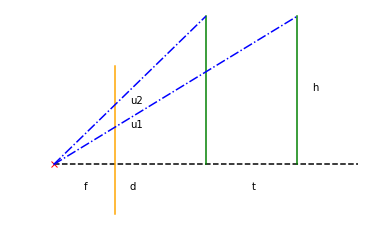

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.axis('off')

plt.plot([0, 10], [0, 0], linestyle="--", color="black")
plt.plot([2, 2], [-1, 2], linestyle="-", color="orange")
plt.plot([5, 5], [0, 3], linestyle="-", color="green")
plt.plot([8, 8], [0, 3], linestyle="-", color="green")
plt.plot([0], [0], "xr")
plt.plot([0, 5], [0, 3], linestyle="-.", color="blue")
plt.plot([0, 8], [0, 3], linestyle="-.", color="blue")
plt.text(1, -0.5,"f" )
plt.text(2.5, -0.5,"d" )
plt.text(6.5, -0.5,"t" )
plt.text(2.5, 0.75, "u1")
plt.text(2.5, 1.25, "u2")
plt.text(8.5, 1.5, "h")

Where f is the focal length, d is the unknown offset from the origin of the original image, h is the target distance from the optical axis, and t is the known additional offset. 

Starting with the assumption that the sensor returns data relative to the intersection of the optical axis with the sensor, we have two lines described by two lines with intersections points at the origin.

$$
\begin{eqnarray}
u_1 & = & f \frac{h}{d+t} \\
u_2 & = & f \frac{h}{d}
\end{eqnarray}
$$

In this contrived example, the solution is relatively simple. For a more realistic example, again ignoring distortion, we can get a more general solution by allowing the images to measure from the top left corner of the image (by adding $c_x$ and $c_y$ offset parameters to the projected 2d points) and incorporating an unknown rotation and initial translation:

$$
\begin{eqnarray}
K & = & \begin{bmatrix} f_x & 0 & c_x \\ 0 & f_y & c_y \\ 0 & 0 & 1 \end{bmatrix} \\
\begin{bmatrix} x \\ y \\ 1 \end{bmatrix} & \propto & K \begin{bmatrix} R & t \end{bmatrix} \begin{bmatrix} X \\ Y \\ Z \\ 1 \end{bmatrix} 
\end{eqnarray}
$$

Where the right side points correspond to the 3d positions of target points. R and t are the rotation and translation of the points into their 3d positions relative to the camera (R is a 3x3 matrix and t is a 3x1 vector).

For the image of the target that is move away by distance t, we have the equation:

$$
\begin{eqnarray}
\begin{bmatrix} x \\ y \\ 1 \end{bmatrix} & \propto & K \begin{bmatrix} I_{3x3} \begin{matrix} 0 \\ 0 \\ t \end{matrix} \end{bmatrix} \begin{bmatrix} R & t\\ 0 & 1 \end{bmatrix} \begin{bmatrix} X \\ Y \\ Z \\ 1 \end{bmatrix} 
\end{eqnarray}
$$

With this parameterization, we have 3 rotation, 3 translation and 4 camera parameters that need to be solved for (10 parameters). So to solve this uniquely, we need at least 3 unique measured points.

The addition of introduces additional paramters to the projection functions:

$$
\begin{eqnarray}
\begin{bmatrix} x \\ y \\ 1 \end{bmatrix} & \propto & K D \left( \begin{bmatrix} R & t \end{bmatrix} \begin{bmatrix} X \\ Y \\ Z \\ 1 \end{bmatrix} \right) \\
\begin{bmatrix} x \\ y \\ 1 \end{bmatrix} & \propto & K D \left(\begin{bmatrix} I_{3x3} \begin{matrix} 0 \\ 0 \\ t \end{matrix} \end{bmatrix} \begin{bmatrix} R & t\\ 0 & 1 \end{bmatrix} \begin{bmatrix} X \\ Y \\ Z \\ 1 \end{bmatrix} \right)
\end{eqnarray}
$$
 
Where $D$ is the undistortion function that takes the 3D points and undistorts them according to the following model:

$$
\begin{eqnarray}
x^` & = & \frac{x}{z} \\
y^` & = & \frac{y}{z} \\
r^2 & = & x^{`2} + y^{`2} \\
x^{``} & = & x^` \left (1 + k_1 r^2 + k_2 r^4 + k_3 r^6 \right) + 2 p_1 x^` y^` + p_2 \left( r^2 + 2 x^{`2} \right) \\
y^{``} & = & y^` \left (1 + k_1 r^2 + k_2 r^4 + k_3 r^6 \right)  + p_1 \left( r^2 + 2 y^{`2} \right) + 2 p_2 x^` y^` \end{eqnarray}
$$

Where $x, y, z$ are the target points in their actual 3d position, $k_1, k_2, k_3$ are the radial distortion parameters and $p_1, p_2$ are the tangential distortion parameters.


In [ ]:
 Whe